In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from einops import repeat, rearrange

## MODEL ARCHITECTURE

In [113]:

class SingleConvBlock(nn.Module):
    def __init__(self, inc, outc):
        super().__init__()
        self.single_conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=inc, out_channels=outc, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.single_conv_block(x)
        x = self.pool(x)
        return x


class SingleDeconvBlock(nn.Module):
    def __init__(self, inc, outc) -> None:
        super().__init__()
        self.single_conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=inc, out_channels=outc, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.single_conv_block(x)
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_channel=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.features = features
        self.input_conv = nn.Conv2d(
            in_channels=in_channel, out_channels=features[0], kernel_size=3, stride=1, padding=1)
        
        self.encoder_list = nn.ModuleList()
        self.encoder_list.append(self.input_conv)   

        """Initialize all necessary encoders"""
        for i in range(0, len(self.features) - 1): 
            single_block = SingleConvBlock(
                inc=self.features[i], outc=self.features[i + 1])
            self.encoder_list.append(single_block)

        self.skip_connections = []


    def forward(self, x):
        """Deprecated"""
        # x = self.input_conv(x)
        # self.skip_connections.append(x)
        # for i in range(0, len(self.features) - 1):
        #     single_block = SingleConvBlock(
        #         inc=self.features[i], outc=self.features[i + 1])
        #     x = single_block(x)

        """New"""
        for i in range(len(self.encoder_list)): 
            encoder = self.encoder_list[i] 
            x = encoder(x) 
            
            self.skip_connections.append(x)

        return x, self.skip_connections


class DecoderBlock(nn.Module):
    def __init__(self, features=[512, 256, 128, 64]):
        super().__init__()
        self.features = features
        self.skip_connection_counter = 0
        self.decoder_list = nn.ModuleList()

        for i in range(len(self.features)): 
            transpose_layer = nn.ConvTranspose2d(
                in_channels=self.features[i] * 2, out_channels=self.features[i], kernel_size=2, stride=2)
            decoder_layer = SingleDeconvBlock(inc=self.features[i] * 2, outc=self.features[i])

            self.decoder_list.append(transpose_layer) 
            self.decoder_list.append(decoder_layer) 


    def forward(self, x, skip_connections):
        """Deprecated"""
        # for i in range(0, len(self.features)):
        #     # pass through deconv layer
        #     x = nn.ConvTranspose2d(
        #         in_channels=self.features[i] * 2, out_channels=self.features[i], kernel_size=2, stride=2)(x)

        #     # get skip connection
        #     skip_connection_input = skip_connections[self.skip_connection_counter]

        #     # concat with skip connection
        #     x = torch.cat((x, skip_connection_input), dim=1)

        #     # get single deconv block
        #     single_block = SingleDeconvBlock(
        #         inc=self.features[i] * 2, outc=self.features[i])

        #     # increase skip connection counter
        #     self.skip_connection_counter += 1

        #     # do forwad pass
        #     x = single_block(x)

        """New"""
        for i in range(0, len(self.decoder_list), 2): 
            # get transpose and deconv layer 
            transpose_layer = self.decoder_list[i]
            single_deconv_block = self.decoder_list[i + 1]

            # pass through transpose 
            x = transpose_layer(x) 

            # get skip connection
            skip_connection_input = skip_connections[self.skip_connection_counter]

            # concat with skip connection
            x = torch.cat((x, skip_connection_input), dim=1)

            # pass through deconv block 
            x = single_deconv_block(x) 

            # increase skip connection counter
            self.skip_connection_counter += 1

        return x
    
class AbsPositionalEncoding1D(nn.Module):
    def __init__(self, tokens, dim):
        super().__init__()
        self.abs_pos_enc = nn.Parameter(torch.randn(1, tokens, dim))

    def forward(self, x):
        batch = x.size()[0]

        return x + repeat(self.abs_pos_enc, 'b ... -> (b tile) ...', tile=batch // self.abs_pos_enc.shape[0])


class Unetmer(nn.Module):

    def __init__(self, inc=1, outc=8, scale=2, original_size=256):
        super().__init__()

        """Define other params"""
        self.original_size = original_size
        self.scale = scale
        self.num_encode_decode_sequence = self.scale * self.scale  # 4
        self.patched_size = int(original_size / self.scale) # 128 
        self.d_model = int((self.patched_size / \
                        (2 ** self.num_encode_decode_sequence)) * (self.patched_size / (2 ** self.num_encode_decode_sequence)))  # 64 || dim model = (size / 2^4) * (size / 2^4)\
        
        """Define layers"""
        self.abs_pos_encoding = AbsPositionalEncoding1D(4096, self.d_model)
        self.transformer = nn.TransformerEncoderLayer(
            d_model=self.d_model, nhead=8, batch_first=True)
        
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.skip_connections_list = []

        self.outputs = []
        self.out_conv = nn.Conv2d(
            in_channels=64, out_channels=outc, kernel_size=3, stride=1, padding=1)

        for i in range(self.num_encode_decode_sequence):
            single_encoder_block = EncoderBlock(inc)
            self.encoder_blocks.append(single_encoder_block)
            self.encoder_blocks.append(SingleConvBlock(inc=512, outc=1024))

            single_decoder_block = DecoderBlock()
            self.decoder_blocks.append(single_decoder_block)


    def split_inputs(self, inputs): 
        """
        inputs should be of shape (batch, channel, size, size) 
        """
        splitted_image_list = []

        for i in range(self.scale):
            for j in range(self.scale):
                splitted_image = inputs[:, :, i * self.patched_size:(i + 1) *
                                self.patched_size, j * self.patched_size:(j + 1) * self.patched_size]
                splitted_image_list.append(splitted_image)

        return splitted_image_list
    
    def join_outputs(self, outputs): 
        y = outputs.shape[1]
        new_output = outputs.reshape(y, 8, self.original_size, self.original_size)

        return new_output

    def forward(self, original_inputs):
        """Convert inputs to list of inputs"""
        inputs = self.split_inputs(original_inputs)

        """Pass through encoder"""
        encoder_block_counter = 0
        for i in range(len(inputs)):
            x = inputs[i]

            # pass through main encoder block
            x, skip_connections = self.encoder_blocks[encoder_block_counter](x)
            skip_connections = skip_connections[::-1]
            self.skip_connections_list.append(skip_connections)

            # pass through bottle neck layer
            x = self.encoder_blocks[encoder_block_counter + 1](x)

            print(f"After passing through encoder: {x.shape}")

            encoder_block_counter += 2

            inputs[i] = x

        print(f"Length skip connection: {len(self.skip_connections_list)}")

        """Pass through Transformers"""
        # flatten to 1D sequence
        for i in range(len(inputs)):
            inputs[i] = inputs[i].flatten(start_dim=2)
        
        # concat to sequence 
        transformer_input = torch.concat(inputs, dim=1)

        # abs positional encoding 
        transformer_input = self.abs_pos_encoding(transformer_input) 

        # pass through transformer 
        transformer_output = self.transformer(transformer_input) 
        
        print(f"Transformer output: {transformer_output.shape}")

        decoder_input = torch.split(
            transformer_output, split_size_or_sections=1024, dim=1)
        decoder_input = list(decoder_input) 

        for i in range(len(decoder_input)): 
            # calculate last dimension 
            new_shape_last_dim = int(decoder_input[i].shape[-1] ** 0.5) 

            # calculate new tensor shape 
            new_shape = (
                decoder_input[i].shape[0], decoder_input[i].shape[1], new_shape_last_dim, new_shape_last_dim)
            
            # reassign decoder input
            decoder_input[i] = torch.reshape(decoder_input[i], new_shape)
        
        for i in decoder_input: 
            print(f"Decoder input: {i.shape}")


        """Pass through decoder"""
        decoder_block_counter = 0
        for i in range(len(decoder_input)):
            x = decoder_input[i]

            # pass through decoder
            x = self.decoder_blocks[decoder_block_counter](
                x, self.skip_connections_list[i])

            print(f"After passing through decoder: {x.shape}")

            x = self.out_conv(x)
            decoder_block_counter += 1

            self.outputs.append(x)

        self.outputs = torch.stack(self.outputs)
        self.outputs = self.join_outputs(self.outputs) 
        print(f"Final model output shape: {self.outputs.shape}")
        return self.outputs

## MODEL TESTING

#### INPUT PATCHING

In [ ]:
a = cv2.imread("../UNETR_MMWHS/files/images/heart0-slice000_axial.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(a, cmap="gray")

In [ ]:
scale = 2
half_size = a.shape[0] // scale

splitted_image_list = []

for i in range(scale): 
    for j in range(scale): 
        splitted_image = a[i * half_size:(i + 1) * half_size, j * half_size:(j+ 1) * half_size]

        splitted_image_list.append(splitted_image)


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16)) 

for i in range(4): 
    axes[i].imshow(splitted_image_list[i])
    axes[i].set_xlabel(f"Split: {i}")

plt.show()

#### TEST INPUT PATCHING ON BATCH 

In [ ]:
a = np.random.rand(4, 1, 256, 256)

scale = 2
half_size = a.shape[2] // scale

splitted_image_list = []

for i in range(scale):
    for j in range(scale):
        splitted_image = a[:, :, i * half_size:(i + 1) *
                           half_size, j * half_size:(j + 1) * half_size]

        print(splitted_image.shape) 
        splitted_image_list.append(splitted_image)

Image order: 122
Image order: 209
Image order: 018
Image order: 049
Image list: (4, 1, 256, 256)
(4, 1, 128, 128)
(4, 1, 128, 128)
(4, 1, 128, 128)
(4, 1, 128, 128)
After splitting shape: (4, 1, 128, 128)
After splitting shape: (4, 1, 128, 128)
After splitting shape: (4, 1, 128, 128)
After splitting shape: (4, 1, 128, 128)
Splitted list shape after squeezing: (4, 4, 128, 128)


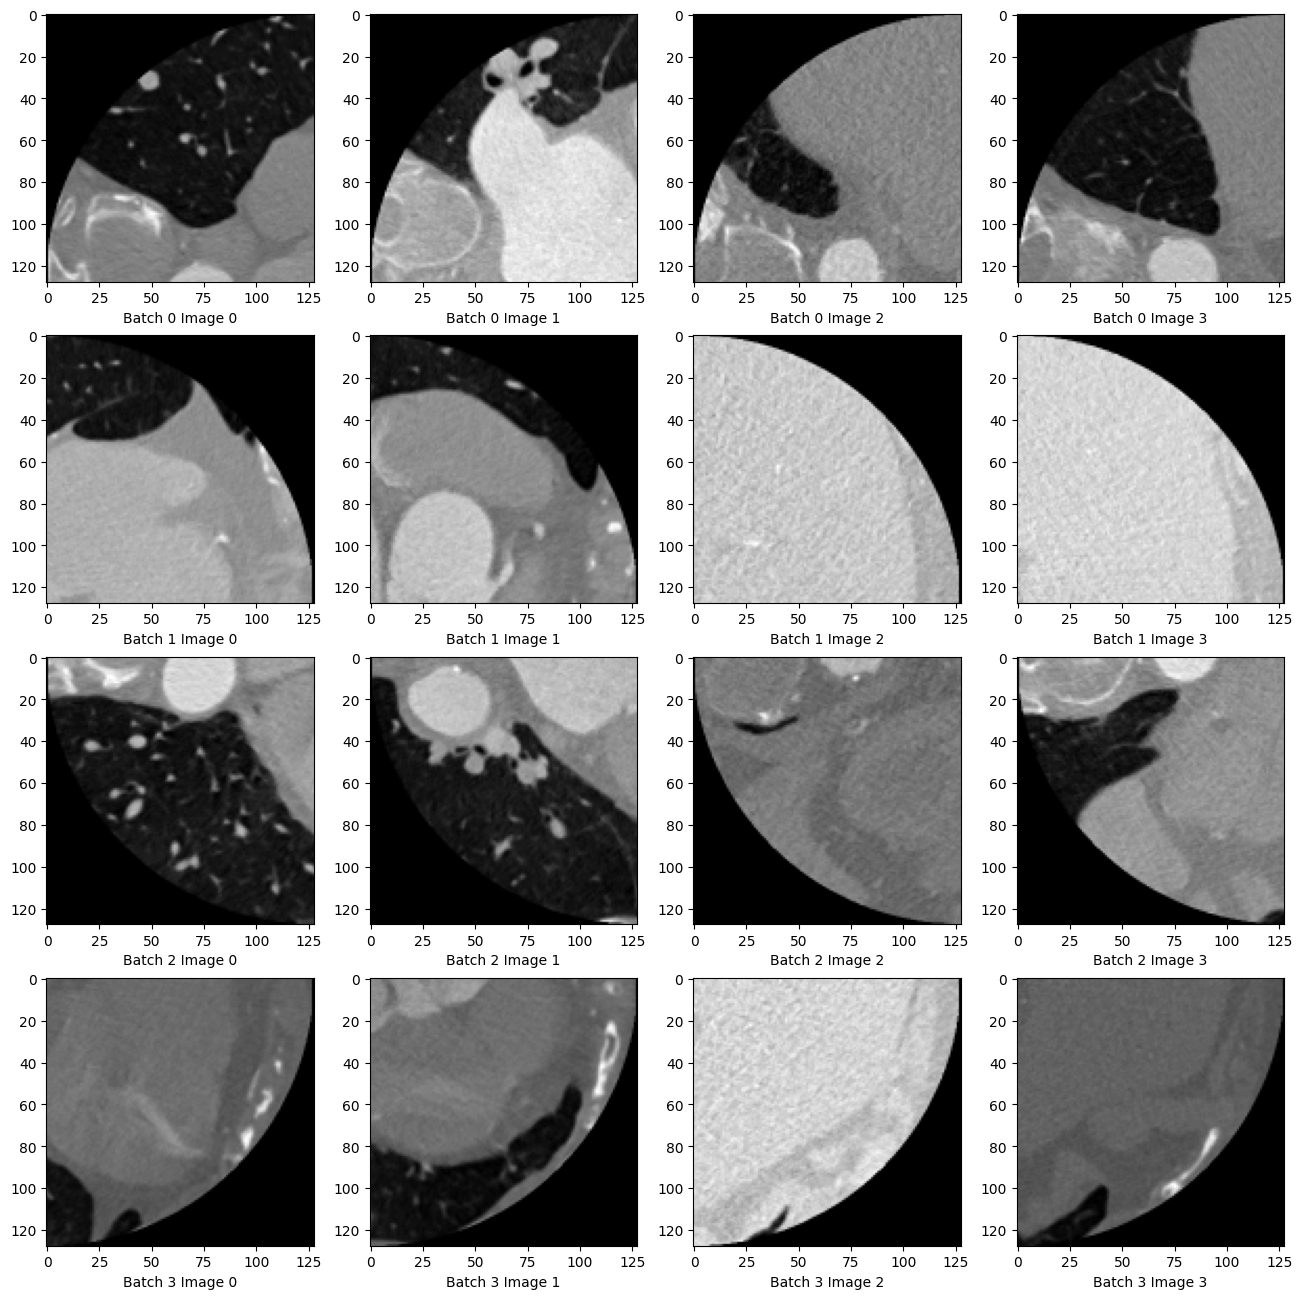

In [29]:
image_list = []

scale = 2
half_size = 256 // scale


for i in range(4): 
    num = np.random.randint(0, 362) 
    formatted_num = "{:03d}".format(num)    
    print(f"Image order: {formatted_num}")
    image_path = f"../UNETR_MMWHS/files/images/heart0-slice{formatted_num}_axial.png"
    array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    array = np.expand_dims(array, axis=0) 
    image_list.append(array) 

image_list = np.array(image_list) 
print(f"Image list: {image_list.shape}")

splitted_image_list = []

for i in range(scale):
    for j in range(scale):
        splitted_image = image_list[:, :, i * half_size:(i + 1) *
                           half_size, j * half_size:(j + 1) * half_size]

        print(splitted_image.shape)
        splitted_image_list.append(splitted_image)

for array in splitted_image_list: 
    print(f"After splitting shape: {array.shape}")

splitted_image_list = np.array(splitted_image_list)
splitted_image_list_squeeze = np.squeeze(splitted_image_list)
print(f"Splitted list shape after squeezing: {splitted_image_list_squeeze.shape}")

nrows = splitted_image_list_squeeze.shape[0]
ncols = splitted_image_list_squeeze.shape[1]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))

for i in range(nrows): 
    for j in range(ncols): 
        img = splitted_image_list_squeeze[i, j, :, :]
        axes[i, j].imshow(img, cmap="gray") 
        axes[i, j].set_xlabel(f"Batch {i} Image {j}")

#### SINGLE IMAGE OUTPUT RECONSTRUCTION

In [30]:
print(splitted_image_list.shape)

(4, 4, 1, 128, 128)


(1, 256, 128)
(1, 256, 128)


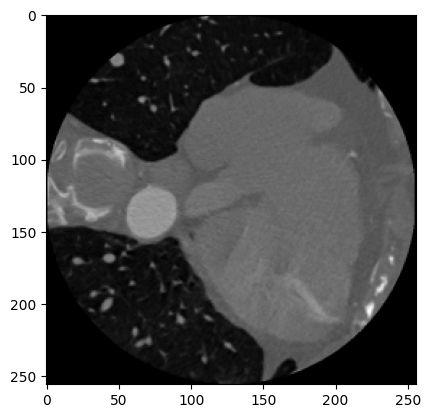

In [52]:
""" 
=> to get 1 patch of image from output of shape: (patch_nums x batch x channel x size x size) => [patch_num, batch_num, :, :, :]
patch_num will be order of patch, i.e (1, 2, 3, 4) with scale = 2
""" 

img1 = splitted_image_list[0, 0, :, :, :]
img2 = splitted_image_list[1, 0, :, :, :]
img3 = splitted_image_list[2, 0, :, :, :]
img4 = splitted_image_list[3, 0, :, :, :]

# fig, axes = plt.subplots(nrows=2, ncols=2) 
# axes[0][0].imshow(np.squeeze(img1), cmap="gray") 
# axes[0][0].set_xlabel("!") 

# axes[0][1].imshow(np.squeeze(img2), cmap="gray")
# axes[0][1].set_xlabel("2")

# axes[1][0].imshow(np.squeeze(img3), cmap="gray")
# axes[1][0].set_xlabel("3")

# axes[1][1].imshow(np.squeeze(img4), cmap="gray")
# axes[1][1].set_xlabel("4")

temp1 = np.concatenate((img1, img3), axis=1)  # shape will be (1, 256, 128)
temp2 = np.concatenate((img2, img4), axis=1)  # shape will be (1, 256, 128)

print(temp1.shape) 
print(temp2.shape) 

# Concatenate along the width (axis=3)
result = np.concatenate((temp1, temp2), axis=-1)

plt.imshow(np.squeeze(result), cmap="gray") 

#### OUTPUT RECONSTRUCTION ON BATCH 

In [59]:
"""Convert patched batches to whole image batches"""


a1 = splitted_image_list[0]
a2 = splitted_image_list[1]
a3 = splitted_image_list[2]
a4 = splitted_image_list[3]

temp1 = np.concatenate((a1, a3), axis=2)  # shape will be (4, 1, 256, 128)
temp2 = np.concatenate((a2, a4), axis=2)  # shape will be (4, 1, 256, 128)

# Concatenate along the width (axis=3)
# shape will be (4, 1, 256, 256)
result = np.concatenate((temp1, temp2), axis=3)

print(result.shape) 

(4, 1, 256, 256)


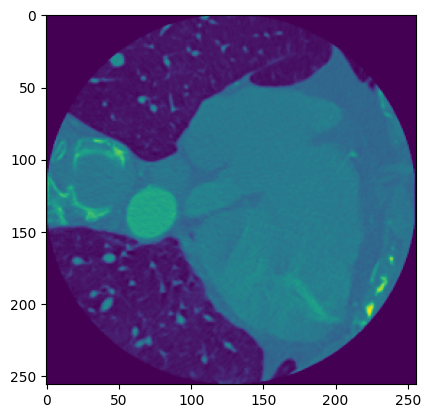

In [60]:
plt.imshow(np.squeeze(result[0, :, :, :]))

In [64]:
"""
splitted_image_list has shape: (4, 4, 1, 128, 128) 
4: patch numbers
4: batch size
1: channel dim
128 x 128: image size
"""

y = splitted_image_list.shape[1]

new_output = splitted_image_list.reshape(y, 1, 256, 256) 

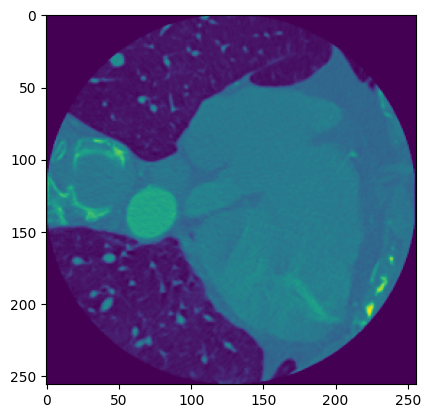

In [65]:
plt.imshow(np.squeeze(result[0, :, :, :]))

#### MODEL INFERENCING

In [ ]:
unetmer = Unetmer(original_size=256)

# inputs have already been splitted
patched_inputs = [torch.rand(4, 1, 128, 128), torch.rand(
    4, 1, 128, 128), torch.rand(4, 1, 128, 128), torch.rand(4, 1, 128, 128)]

outputs = unetmer(patched_inputs)
print("-" * 50)

for i in outputs:
    print(f"Model output: {i.shape}")

In [114]:
unetmer = Unetmer(original_size=256)

# inputs have not been splitted
normal_input = torch.rand(4, 1, 256, 256) 

outputs = unetmer(normal_input)
print("-" * 50)

for i in outputs:
    print(f"Model output: {i.shape}")



After passing through encoder: torch.Size([4, 1024, 8, 8])
After passing through encoder: torch.Size([4, 1024, 8, 8])
After passing through encoder: torch.Size([4, 1024, 8, 8])
After passing through encoder: torch.Size([4, 1024, 8, 8])
Length skip connection: 4
Transformer output: torch.Size([4, 4096, 64])
Decoder input: torch.Size([4, 1024, 8, 8])
Decoder input: torch.Size([4, 1024, 8, 8])
Decoder input: torch.Size([4, 1024, 8, 8])
Decoder input: torch.Size([4, 1024, 8, 8])
After passing through decoder: torch.Size([4, 64, 128, 128])
After passing through decoder: torch.Size([4, 64, 128, 128])
After passing through decoder: torch.Size([4, 64, 128, 128])
After passing through decoder: torch.Size([4, 64, 128, 128])
Final model output shape: torch.Size([4, 8, 256, 256])
--------------------------------------------------
Model output: torch.Size([8, 256, 256])
Model output: torch.Size([8, 256, 256])
Model output: torch.Size([8, 256, 256])
Model output: torch.Size([8, 256, 256])


## MODEL RELATED INFORMATION 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
num_params = count_parameters(unetmer)
print(f"The model has {num_params} trainable parameters.")